In [748]:
# Load dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine, text
import pymc as pm
import arviz as az
from scipy.stats import zscore

# Define the SQLalchemy engine
engine = create_engine(f"sqlite:////Users/JO/PhD/neuro-ascertainment/data/db.sqlite")

# Read the SQL query from the file
with open('/Users/JO/PhD/neuro-ascertainment/candidate-queries/hospital-admission-concept/hospital-admission-concept.sql', 'r') as file:
    query = file.read()

SEED = 20
rng = np.random.default_rng(SEED)

def count_id(df):
    LopNr = df['LopNr'].nunique() if 'LopNr' in df else 'Column missing'
    VtfId_LopNr = df['VtfId_LopNr'].nunique() if 'VtfId_LopNr' in df else 'Column missing'
    HADM_ID = df['HADM_ID'].nunique() if 'HADM_ID' in df else 'Column missing'
    return print(f'Unique patients: {LopNr} | Unique SIR admits: {VtfId_LopNr} | Unique PAR admits: {HADM_ID}')

In [749]:
q = query + "SELECT * FROM DAOH_90_STEP_3"
d = pd.read_sql(q, engine)
d["InskrTidPunkt"] = pd.to_datetime(d.InskrTidPunkt, unit="s")
d["INDATUM"] = pd.to_datetime(d.INDATUM * 86400, unit="s")
d["UTDATUM"] = pd.to_datetime(d.UTDATUM * 86400, unit="s")


In [750]:
d.query("LopNr == 53943.0")

,VtfId_LopNr,LopNr,InskrTidPunkt,AvdNamn,S_INDATUM,S_INDATUM_90,INDATUM,UTDATUM,HADM_ID,HOSPITAL_LOS,...,PROPER_UTDATUM:1,HOSPITAL_LOS_ALIVE,ADM_GROUP,min_INDATUM,max_UTDATUM,ADMITTED_DAYS,Diagnos,Op,MVO,Sjukhus
77044,169643.0,53943.0,2020-03-15 14:55:00,Uppsala,18336,18425,2020-03-15,2020-03-17,299737,3,...,18337.0,2.0,1,18336,18338,3,I609 I638,AA041 SB400 YFA00 YJA10 YJD30 YKA02,331,12001
77310,169882.0,53943.0,2020-03-15 12:30:00,Västerås,18336,18425,2020-03-15,2020-03-17,299737,3,...,18337.0,2.0,1,18336,18338,3,I609 I638,AA041 SB400 YFA00 YJA10 YJD30 YKA02,331,12001


In [751]:
q2 = query + "SELECT * FROM SUMMARY_TABLE"
d2 = pd.read_sql(q2, engine)

In [752]:
d2["sir_adm_time"] = pd.to_datetime(d2.sir_adm_time, unit="s")
d2["sir_dsc_time"] = pd.to_datetime(d2.sir_dsc_time, unit="s")
d2["par_adm_date"] = pd.to_datetime(d2.par_adm_date * 86400, unit="s")
d2["par_dsc_date"] = pd.to_datetime(d2.par_dsc_date * 86400, unit="s")


In [753]:
d2

,LopNr,VtfId_LopNr,HADM_ID,par_tertiary_center,par_adm_date,par_dsc_date,sex_female,age,DX_GROUP,DX_ORDER,...,d30,d90,d180,d365,days_alive,death_date,HOSPITAL_LOS,HOSPITAL_LOS_ALIVE,DAOH_90,DAOH_180
0,4.0,101071.0,22,Norrlands universitetssjukhus,2010-04-22,2010-05-06,1,64.0,ABM,1,...,0,0,0,0,NaN,None,15.0,NaN,72.0,162.0
1,8.0,102868.0,43,Universitetssjukhuset i Linköping,2010-06-15,2010-07-05,1,68.0,ASAH,1,...,0,0,0,0,NaN,None,35.0,NaN,55.0,145.0
2,12.0,173440.0,47,"Karolinska universitetssjukhuset, Solna",2020-09-07,2020-09-08,1,74.0,TBI,1,...,0,0,0,0,NaN,None,33.0,NaN,48.0,138.0
3,20.0,177516.0,84,Universitetssjukhuset i Lund,2021-04-22,2021-04-23,0,38.0,TBI,1,...,0,0,0,0,NaN,None,5.0,NaN,81.0,171.0
4,23.0,113329.0,101,"Karolinska universitetssjukhuset, Solna",2011-12-09,2011-12-22,1,58.0,TUM,1,...,0,0,0,0,449.0,20130305,25.0,450.0,63.0,134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16381,64555.0,101278.0,359190,"Karolinska universitetssjukhuset, Solna",2010-03-10,2010-03-11,0,78.0,TBI,1,...,1,1,1,1,1.0,20100311,2.0,2.0,0.0,0.0
16382,64559.0,144975.0,359213,"Karolinska universitetssjukhuset, Solna",2016-09-28,2016-09-30,1,76.0,SEP,1,...,0,0,0,1,329.0,20170823,29.0,330.0,50.0,128.0
16383,64562.0,119881.0,359252,"Karolinska universitetssjukhuset, Solna",2012-10-18,2012-10-23,0,80.0,TBI,1,...,1,1,1,1,5.0,20121023,6.0,6.0,0.0,0.0
16384,64565.0,149034.0,359274,Universitetssjukhuset i Lund,2017-05-08,2017-05-09,1,89.0,AIS,1,...,1,1,1,1,2.0,20170510,3.0,3.0,0.0,0.0


In [754]:
i = np.random.choice(d2.query("days_alive <4").LopNr.unique())
d2.query(f"LopNr == {i}")[["sir_adm_time", "sir_dsc_time", "par_adm_date", "par_dsc_date", "death_date", "days_alive", "DAOH_90", "HOSPITAL_LOS", "HOSPITAL_LOS_ALIVE"]]

,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,death_date,days_alive,DAOH_90,HOSPITAL_LOS,HOSPITAL_LOS_ALIVE
5719,2010-12-08 08:32:00,2010-12-10 02:00:00,2010-12-08,2010-12-10,20101209,1.0,0.0,3.0,2.0


In [743]:
d2.groupby("par_tertiary_center").DAOH_180.median()

par_tertiary_center
Akademiska sjukhuset                       100.0
Karolinska universitetssjukhuset, Solna    120.0
Norrlands universitetssjukhus               95.0
Sahlgrenska universitetssjukhuset          122.0
Universitetssjukhuset i Linköping          136.0
Universitetssjukhuset i Lund               122.0
Name: DAOH_180, dtype: float64

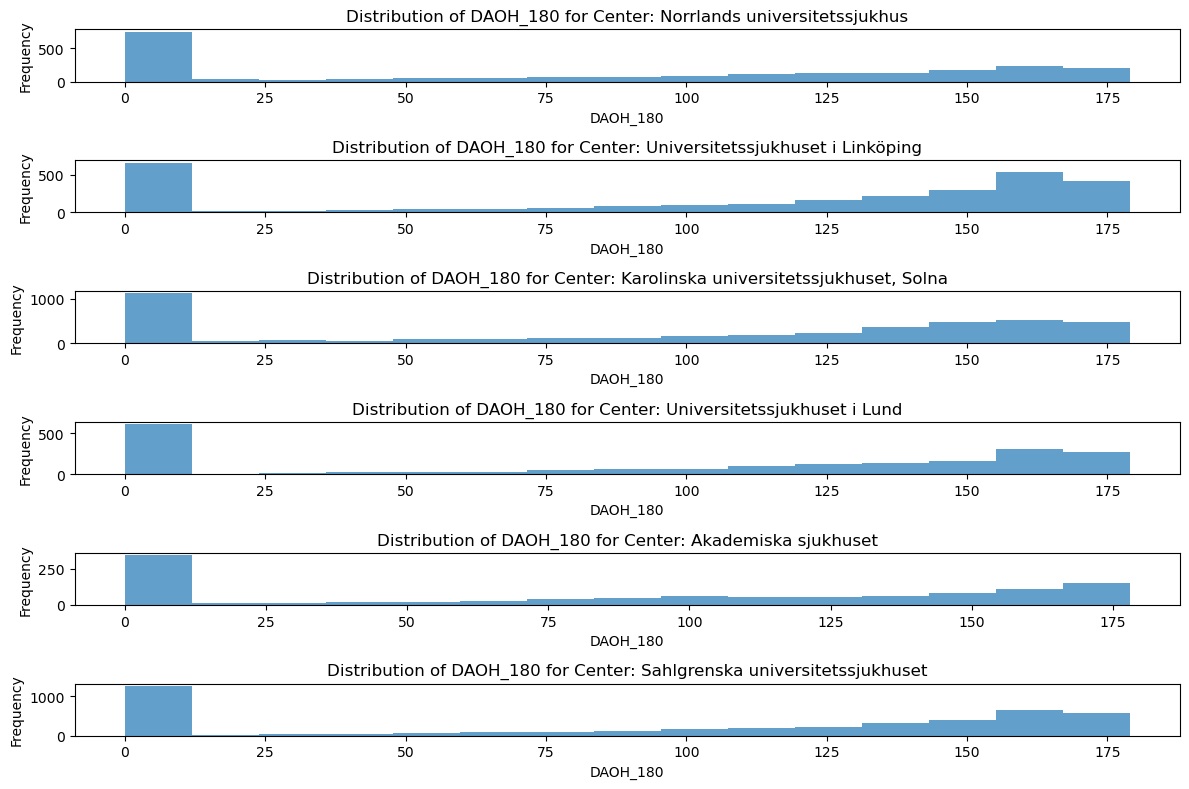

In [729]:
d3 = d2

unique_centers = d3['par_tertiary_center'].unique()
plt.figure(figsize=(12, 8))

for i, center in enumerate(unique_centers, start=1):
    plt.subplot(len(unique_centers), 1, i)
    plt.hist(d3[d3['par_tertiary_center'] == center]['DAOH_180'], bins=15, alpha=0.7)
    plt.title(f'Distribution of DAOH_180 for Center: {center}')
    plt.xlabel('DAOH_180')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [742]:
d2.groupby("par_tertiary_center").SAPS_hypertension.mean()

par_tertiary_center
Akademiska sjukhuset                       0.031088
Karolinska universitetssjukhuset, Solna    0.046306
Norrlands universitetssjukhus              0.008901
Sahlgrenska universitetssjukhuset          0.047297
Universitetssjukhuset i Linköping          0.021763
Universitetssjukhuset i Lund               0.033714
Name: SAPS_hypertension, dtype: float64

In [ ]:
d2.SAPS_total_score

### PAR_HADM
PAR_HADM contains all PAR admits:

In [2]:
query_PAR_HADM = query + "SELECT * FROM PAR_HADM"
PAR_HADM = pd.read_sql(query_PAR_HADM, engine)
count_id(PAR_HADM)

Unique patients: 59333 | Unique SIR admits: Column missing | Unique PAR admits: 359305


### T_ICU_ADMISSIONS
All ICU admissions at tertiary a ICU

In [3]:
query_T_ICU_ADMISSIONS = query + "SELECT * FROM T_ICU_ADMISSIONS"
T_ICU_ADMISSIONS = pd.read_sql(query_T_ICU_ADMISSIONS, engine)
count_id(T_ICU_ADMISSIONS)

Unique patients: 25362 | Unique SIR admits: 30335 | Unique PAR admits: Column missing


### T_ICU_ADMISSIONS_MATCHED_WITH_PAR
Left join PAR admissions (with certain criteria) on T_ICU_ADMISSIONS on LopNr (patient ID) . Patients are lost at this step as they do not have a proper patient ID ("reservnummer").

Note that each patient can have several ICU admits here. Also, each ICU admit can be matched with several PAR admits.

In [4]:
query_T_ICU_ADMISSIONS_MATCHED_WITH_PAR = query + "SELECT * FROM T_ICU_ADMISSIONS_MATCHED_WITH_PAR"
T_ICU_ADMISSIONS_MATCHED_WITH_PAR = pd.read_sql(query_T_ICU_ADMISSIONS_MATCHED_WITH_PAR, engine)
count_id(T_ICU_ADMISSIONS_MATCHED_WITH_PAR)

Unique patients: 21806 | Unique SIR admits: 25366 | Unique PAR admits: 29486


### T_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX
Inferred diagnosis for the PAR admit is added to T_ICU_ADMISSIONS_MATCHED_WITH_PAR. In a few cases the criteria for several DX are fulfilled.

In [5]:
query_T_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX = query + "SELECT * FROM T_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX"
T_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX = pd.read_sql(query_T_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX, engine)
count_id(T_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX)

Unique patients: 21806 | Unique SIR admits: 25366 | Unique PAR admits: 29486


### T_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX_TIME_HIERARCHY
This takes care of situations where a ICU admit is matched with several PAR admits. Here a column called DX_ORDER is introduced, ranking PAR admits based on "relevancy". The earliest admit is most relevant. If there is a tie on date, a diagnostic group hierarchy is used to decide rank. All rows with "OTHER" dx are removed, that's why we loose patients in this step.

In [6]:
query_TIME_HIERARCHY= query + "SELECT * FROM T_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX_TIME_HIERARCHY"
TIME_HIERARCHY  = pd.read_sql(query_TIME_HIERARCHY, engine)
count_id(TIME_HIERARCHY)

Unique patients: 16386 | Unique SIR admits: 19181 | Unique PAR admits: 20350


In [7]:
small_d = TIME_HIERARCHY[['VtfId_LopNr','InskrTidPunkt', 'UtskrTidPunkt', 'HADM_ID', 'MVO', 'LopNr', 'INDATUM', 'UTDATUM', 'DX_GROUP', 'DIAGNOS', 'DX_ORDER']]
small_d['INDATUM'] = pd.to_datetime(small_d['INDATUM'], unit='D')
small_d['UTDATUM'] = pd.to_datetime(small_d['UTDATUM'], unit='D')
small_d['InskrTidPunkt'] = pd.to_datetime(small_d['InskrTidPunkt'], unit='s').dt.normalize()
small_d['UtskrTidPunkt'] = pd.to_datetime(small_d['UtskrTidPunkt'], unit='s').dt.normalize()

filtered_df = small_d[small_d.groupby('VtfId_LopNr')['VtfId_LopNr'].transform('size') > 1]
filtered_df['timediff_to_sir'] = filtered_df['INDATUM'] - filtered_df['InskrTidPunkt']

/var/folders/s_/hnbjtb757x10k0pyf6_x_9mw0000gn/T/ipykernel_90935/2561574566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_d['INDATUM'] = pd.to_datetime(small_d['INDATUM'], unit='D')
/var/folders/s_/hnbjtb757x10k0pyf6_x_9mw0000gn/T/ipykernel_90935/2561574566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_d['UTDATUM'] = pd.to_datetime(small_d['UTDATUM'], unit='D')
/var/folders/s_/hnbjtb757x10k0pyf6_x_9mw0000gn/T/ipykernel_90935/2561574566.py:4: SettingWithCopyWarning: 
A value is trying

In [8]:
check_vtf = rng.choice(filtered_df['VtfId_LopNr'], 1)
filtered_df.query(f"VtfId_LopNr == {check_vtf}")

,VtfId_LopNr,InskrTidPunkt,UtskrTidPunkt,HADM_ID,MVO,LopNr,INDATUM,UTDATUM,DX_GROUP,DIAGNOS,DX_ORDER,timediff_to_sir
20788,177718.0,2021-05-03,2021-05-06,254484,301,45807.0,2021-05-03,2021-05-03,TBI,S066 S065 S028 I109 I252 Z867A,1,0 days
20789,177718.0,2021-05-03,2021-05-06,254485,331,45807.0,2021-05-03,2021-05-10,TBI,S066 S062 I109 E831,2,0 days


### T_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX_HIERARCHY_TIME
Same thing as above, but hierarchy first.

In [9]:
query_HIERARCHY_TIME= query + "SELECT * FROM T_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX_HIERARCHY_TIME"
HIERARCHY_TIME  = pd.read_sql(query_HIERARCHY_TIME, engine)
count_id(HIERARCHY_TIME)

Unique patients: 16386 | Unique SIR admits: 19181 | Unique PAR admits: 20350


In [10]:
small_d = HIERARCHY_TIME[['VtfId_LopNr','InskrTidPunkt', 'UtskrTidPunkt', 'HADM_ID', 'MVO', 'LopNr', 'INDATUM', 'UTDATUM', 'DX_GROUP', 'DIAGNOS', 'DX_ORDER']]
small_d['INDATUM'] = pd.to_datetime(small_d['INDATUM'], unit='D')
small_d['UTDATUM'] = pd.to_datetime(small_d['UTDATUM'], unit='D')
small_d['InskrTidPunkt'] = pd.to_datetime(small_d['InskrTidPunkt'], unit='s').dt.normalize()
small_d['UtskrTidPunkt'] = pd.to_datetime(small_d['UtskrTidPunkt'], unit='s').dt.normalize()

filtered_df = small_d[small_d.groupby('VtfId_LopNr')['VtfId_LopNr'].transform('size') > 1]
filtered_df['timediff_to_sir'] = filtered_df['INDATUM'] - filtered_df['InskrTidPunkt']

/var/folders/s_/hnbjtb757x10k0pyf6_x_9mw0000gn/T/ipykernel_90935/2839594063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_d['INDATUM'] = pd.to_datetime(small_d['INDATUM'], unit='D')
/var/folders/s_/hnbjtb757x10k0pyf6_x_9mw0000gn/T/ipykernel_90935/2839594063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_d['UTDATUM'] = pd.to_datetime(small_d['UTDATUM'], unit='D')
/var/folders/s_/hnbjtb757x10k0pyf6_x_9mw0000gn/T/ipykernel_90935/2839594063.py:4: SettingWithCopyWarning: 
A value is trying

In [11]:
check_vtf = rng.choice(filtered_df['VtfId_LopNr'], 1)
filtered_df.query(f"VtfId_LopNr == {check_vtf}")

,VtfId_LopNr,InskrTidPunkt,UtskrTidPunkt,HADM_ID,MVO,LopNr,INDATUM,UTDATUM,DX_GROUP,DIAGNOS,DX_ORDER,timediff_to_sir
6434,125746.0,2013-12-20,2013-12-27,97114,331,17324.0,2013-12-20,2013-12-27,ICH,I614,1,0 days
6435,125746.0,2013-12-20,2013-12-27,97115,109,17324.0,2013-12-27,2014-01-29,ICH,I614 I109 I489 E039,2,7 days


### SUMMARY_TABLE
Finally, using the time and dx hierarchy as tiebreakers. We choose the first ICU admit for each patient and match it with a PAR admit.

In [12]:
query_DESC_PAR = query + "SELECT * FROM SUMMARY_TABLE"
DESC = pd.read_sql(query_DESC_PAR, engine)
DESC

DESC['par_adm_date'] = pd.to_datetime(DESC['par_adm_date'], unit='D')
DESC['par_dsc_date'] = pd.to_datetime(DESC['par_dsc_date'], unit='D')
DESC['sir_adm_time'] = pd.to_datetime(DESC['sir_adm_time'], unit='s').dt.normalize()
DESC['sir_dsc_time'] = pd.to_datetime(DESC['sir_dsc_time'], unit='s').dt.normalize()

In [13]:
count_id(DESC)

Unique patients: 16386 | Unique SIR admits: 16386 | Unique PAR admits: 16386


In [16]:
s = DESC.groupby('DX_GROUP').agg({'age': 'mean', 'sex_female': 'mean', 'sir_total_time': 'median', 'SAPS_GCS': 'median', 'any_AMV': 'mean', 'd30': 'mean', 'DAOH_90': 'median', 'DAOH_180': 'median', 'VtfId_LopNr': 'count'})
s.rename(columns={'VtfId_LopNr': 'n'}).sort_values(by='n', ascending=False)

,age,sex_female,sir_total_time,SAPS_GCS,any_AMV,d30,DAOH_90,DAOH_180,n
DX_GROUP,,,,,,,,,
TBI,56.645415,0.264192,2842.5,10.0,0.711572,0.191048,43.0,129.0,4580
ASAH,58.611969,0.630792,6822.5,14.0,0.588079,0.152751,50.0,138.0,4144
ICH,60.123437,0.393707,4052.0,8.0,0.769262,0.315046,0.0,73.0,2479
AIS,65.313184,0.386660,2155.0,10.0,0.735279,0.314747,3.0,77.0,1919
CFX,61.551802,0.236486,3603.0,15.0,0.693694,0.108108,12.0,91.0,888
ABM,56.833066,0.441413,4095.0,11.0,0.731942,0.123596,52.0,140.0,623
SDH,66.837121,0.314394,2281.5,11.0,0.611742,0.240530,50.5,135.5,528
SEP,57.295302,0.463087,1415.0,7.0,0.720358,0.096197,75.0,161.0,447
TUM,52.432515,0.438650,2852.0,11.0,0.677914,0.190184,35.0,105.5,326
